In [1]:
#from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import os
import pandas as pd
import datetime as dt

from functools import partial

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from tensorflow.python.keras import backend as K

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

**Data manipulation functions**

In [2]:
def format_multiple_bins_for_LSTM(
    dataframe,
    target_column_index,
    history_size,
    target_size, 
    step
):

    data = []
    labels = []
    
    spatial_bins = dataframe.groupby(['lat', 'lon'])
    
    for bin_name, spatial_bin in spatial_bins:
        
        spatial_bin = spatial_bin.sort_index()
        
        spatial_bin = np.array(spatial_bin.values)
        target = spatial_bin[:, target_column_index]
        
        bin_data = []
        bin_labels = []
    
        start_index = history_size
        end_index = len(spatial_bin) - target_size

        for i in range(start_index, end_index):
            indices = range(i - history_size, i, step)
            bin_data.append(spatial_bin[indices])
            bin_labels.append(target[i + target_size])

        data.append(np.array(bin_data))
        labels.append(np.array(bin_labels))

    return data, labels
    

def plot_metrics(history):
    metrics =  ['loss', 'auc', 'f1']
    
    plt.subplots(1,4,figsize=(10.5,3.5))
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(1,3,n+1)
        plt.plot(history.epoch,  history.history[metric], color='royalblue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color='royalblue', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.title(name)
        
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
        
    elif metric == 'auc':
        plt.ylim([0.8,1])
        
    else:
        #plt.ylim([0,1])
        plt.legend()
        
    plt.tight_layout()
    plt.savefig('../figures/parallel_LSTM_learning_curves.png', bbox_inches='tight')
    
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    normalized_cm = np.empty([2, 2])
    normalized_cm[0][0] = cm[0][0] / (cm[0][0] + cm[0][1])
    normalized_cm[0][1] = cm[0][1] / (cm[0][0] + cm[0][1])
    normalized_cm[1][0] = cm[1][0] / (cm[1][0] + cm[1][1])
    normalized_cm[1][1] = cm[1][1] / (cm[1][0] + cm[1][1])
    plt.figure(figsize=(5,5))
    sns.heatmap(normalized_cm, annot=True)
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('No fire (True Negatives): ', cm[0][0])
    print('False alarms (False Positives): ', cm[0][1])
    print('Fires missed (False Negatives): ', cm[1][0])
    print('Fires detected (True Positives): ', cm[1][1])
    print('Total fires: ', np.sum(cm[1]))
    
    plt.tight_layout()
    plt.savefig('../figures/parallel_LSTM_confusion_matrix.png', bbox_inches='tight')
    
def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [3]:
data_file = '../data/training_data/1992-2015_training_data_added_features.csv'

# Datatypes for dataframe loading
dtypes = {
    'lat': float,
    'lon': float,
    'weather_bin_year': int,
    'weather_bin_month': int,
    'weather_bin_day': int,
    'air.2m': float,
    'apcp': float,
    'rhum.2m': float,
    'dpt.2m': float,
    'pres.sfc': float,
    'uwnd.10m': float,
    'vwnd.10m': float,
    'veg': float,
    'vis': float,
    'ignition': float,
    'mean.air.2m': float,
    'mean.apcp': float,
    'mean.rhum.2m': float,
    'mean.dpt.2m': float,
    'mean.pres.sfc': float,
    'mean.uwnd.10m': float,
    'mean.vwnd.10m': float,
    'mean.veg': float,
    'mean.vis': float,
    'max.air.2m': float,
    'max.apcp': float,
    'max.rhum.2m': float,
    'max.dpt.2m': float,
    'max.pres.sfc': float,
    'max.uwnd.10m': float,
    'max.vwnd.10m': float,
    'max.veg': float,
    'max.vis': float,
    'min.air.2m': float,
    'min.apcp': float,
    'min.rhum.2m': float,
    'min.dpt.2m': float,
    'min.pres.sfc': float,
    'min.uwnd.10m': float,
    'min.vwnd.10m': float,
    'min.veg': float,
    'min.vis': float,
    'total_fires': float

}

# Features to use during training 
features = [
    'lat',
    'lon',
    'weather_bin_month',
    'veg',
    'ignition',
    'mean.air.2m',
    'mean.apcp',
    'mean.rhum.2m',
    'mean.dpt.2m',
    'mean.pres.sfc',
    'mean.uwnd.10m',
    'mean.vwnd.10m',
    'mean.vis',
    'max.air.2m',
    'max.apcp',
    'max.rhum.2m',
    'max.dpt.2m',
    'max.pres.sfc',
    'max.uwnd.10m',
    'max.vwnd.10m',
    'max.vis',
    'min.air.2m',
    'min.apcp',
    'min.rhum.2m',
    'min.dpt.2m',
    'min.pres.sfc',
    'min.uwnd.10m',
    'min.vwnd.10m',
    'min.vis',
    'total_fires'
]

features_to_scale = [
    'lat',
    'lon',
    'veg',
    'mean.air.2m',
    'mean.apcp',
    'mean.rhum.2m',
    'mean.dpt.2m',
    'mean.pres.sfc',
    'mean.uwnd.10m',
    'mean.vwnd.10m',
    'mean.vis',
    'max.air.2m',
    'max.apcp',
    'max.rhum.2m',
    'max.dpt.2m',
    'max.pres.sfc',
    'max.uwnd.10m',
    'max.vwnd.10m',
    'max.vis',
    'min.air.2m',
    'min.apcp',
    'min.rhum.2m',
    'min.dpt.2m',
    'min.pres.sfc',
    'min.uwnd.10m',
    'min.vwnd.10m',
    'min.vis',
    'total_fires'
]

In [4]:
raw_data = pd.read_csv(data_file, index_col=0, parse_dates=True, dtype=dtypes)

In [5]:
# Pull out columns of intrest
data = raw_data[features]

In [6]:
# One hot encode month
column_names = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'Septermber',
    'October',
    'November',
    'December'
]


onehot_encoder = OneHotEncoder(sparse=False)

# Training data
month = np.array(data['weather_bin_month']).reshape(-1, 1)
onehot_month = onehot_encoder.fit_transform(month)

data.drop('weather_bin_month', axis=1, inplace=True)
onehot_month_df = pd.DataFrame(onehot_month, columns=column_names)

onehot_month_df['datetime'] = pd.to_datetime(data.index)
onehot_month_df = onehot_month_df.set_index('datetime')
data = pd.concat([data, onehot_month_df], axis=1)

/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
# Scale data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features_to_scale])
data[features_to_scale] = scaled_features

In [8]:
# Sort by datetime index
data = data.sort_index()

In [9]:
# Split data up into training, testing and validation sets
test_data = data.tail(int(len(data)*0.1))
leftover_data = data.iloc[:-int(len(data)*0.1)]

validation_data = data.tail(int(len(leftover_data)*0.3))
training_data = data.iloc[:-int(len(leftover_data)*0.3)]

In [10]:
training_data.head()

,lat,lon,veg,ignition,mean.air.2m,mean.apcp,mean.rhum.2m,mean.dpt.2m,mean.pres.sfc,mean.uwnd.10m,...,March,April,May,June,July,August,Septermber,October,November,December
1992-01-01,1.253218,-0.386786,0.808603,0.0,-1.803527,-0.272473,1.500833,-0.812006,-0.915011,-1.560149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-01-01,0.111205,-1.142901,0.742635,0.0,-0.563601,-0.272473,0.718705,0.237957,1.197060,-1.695307,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-01-01,1.364131,-0.413964,-0.409607,0.0,-1.806304,-0.272473,1.479213,-0.831262,-1.205457,-0.587206,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-01-01,0.572284,-1.119195,0.610699,0.0,-0.801186,-0.272473,0.747838,-0.036173,0.917379,-0.614216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-01-01,1.145318,-1.124902,0.368816,0.0,-0.842296,-0.272473,1.098187,0.169857,0.771371,-0.066510,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Split data into 410 member lists, one element for each geospatial bin (and network input)
# each element of the list contains samples with a duration of past_history
target_column_index = 3
past_history = 2
future_target = 1
step = 1

x_train, y_train = format_multiple_bins_for_LSTM(
    training_data, 
    target_column_index, 
    past_history,
    future_target, 
    step,
)

x_validation, y_validation = format_multiple_bins_for_LSTM(
    validation_data, 
    target_column_index, 
    past_history,
    future_target, 
    step,
)

In [12]:
print("x_train is of type {} with length {}, each member has shape {}.".format(type(x_train), len(x_train), x_train[0].shape))
print("y_train is of type {} with length {}, each member has shape {}.".format(type(y_train), len(y_train), y_train[0].shape))

x_train is of type <class 'list'> with length 410, each member has shape (6396, 2, 41).
y_train is of type <class 'list'> with length 410, each member has shape (6396,).


In [13]:
# Trim the number of samples in each bin so that they are all the same.
# at the same time, reshape y so that it is number of samples by number of 
# geospatial bins

sample_sizes = []

for sample in y_train:
    sample_sizes.append(len(sample))
    
smallest_sample = min(sample_sizes)

y_train_reshaped = []

for i in range(smallest_sample):
    y = []
    for j in range(len(y_train)):
        try:
            y.append(y_train[j][i])
        except:
            print("Index out of range")
    
    y_train_reshaped.append(np.array(y))
    
trimmed_x_training = []    
    
for sample in x_train:
    trimmed_sample = sample[-smallest_sample:,:]
    trimmed_x_training.append(trimmed_sample)

In [14]:
# Trim the number of samples in each bin so that they are all the same.
# at the same time, reshape y so that it is number of samples by number of 
# geospatial bins

sample_sizes = []

for sample in y_validation:
    sample_sizes.append(len(sample))
    
smallest_sample = min(sample_sizes)
y_validation_reshaped = []

for i in range(smallest_sample):
    y = []
    for j in range(len(y_validation)):
        try:
            y.append(y_validation[j][i])
        except:
            print("Index out of range")
    
    y_validation_reshaped.append(np.array(y))
    
trimmed_x_validation = []    
    
for sample in x_validation:
    trimmed_sample = sample[-smallest_sample:,:]
    trimmed_x_validation.append(trimmed_sample)

In [15]:
print("trimmed_x_training is of type {} with length {}, each member has shape {}.".format(type(trimmed_x_training), len(trimmed_x_training), trimmed_x_training[0].shape))
print("y_train_reshaped is of type {} with length {}, each member has shape {}.".format(type(y_train_reshaped), len(y_validation_reshaped), y_train_reshaped[0].shape))
print()
print("trimmed_x_validation is of type {} with length {}, each member has shape {}.".format(type(trimmed_x_validation), len(trimmed_x_validation), trimmed_x_validation[0].shape))
print("y_validation_reshaped is of type {} with length {}, each member has shape {}.".format(type(y_validation_reshaped), len(y_validation_reshaped), y_validation_reshaped[0].shape))

trimmed_x_training is of type <class 'list'> with length 410, each member has shape (6396, 2, 41).
y_train_reshaped is of type <class 'list'> with length 2363, each member has shape (410,).

trimmed_x_validation is of type <class 'list'> with length 410, each member has shape (2363, 2, 41).
y_validation_reshaped is of type <class 'list'> with length 2363, each member has shape (410,).


In [33]:
# Trim each sample again to be a multiple of the batch size so we
# can do minibatch gradient descent - Note: this is apparently 
# only actualy required for statefull LSTMs

BATCH_SIZE = 500

for i in range(len(x_train)):
    start_index = (trimmed_x_training[i].shape[0] - (trimmed_x_training[i].shape[0] % BATCH_SIZE))
    end_index = trimmed_x_training[i].shape[0]

    trimmed_x_training[i] = np.delete(trimmed_x_training[i], range(start_index, end_index), axis=0)

y_train_reshaped = np.delete(y_train_reshaped, range(start_index, end_index), axis=0)

for i in range(len(y_train)):
    start_index = (trimmed_x_validation[i].shape[0] - (trimmed_x_validation[i].shape[0] % BATCH_SIZE))
    end_index = trimmed_x_validation[i].shape[0]

    trimmed_x_validation[i] = np.delete(trimmed_x_validation[i], range(start_index, end_index), axis=0)

y_validation_reshaped = np.delete(y_validation_reshaped, range(start_index, end_index), axis=0)

In [34]:
print("trimmed_x_training is of type {} with length {}, each member has shape {}.".format(type(trimmed_x_training), len(trimmed_x_training), trimmed_x_training[0].shape))
print("y_train_reshaped is of type {} with shape {}.".format(type(y_train_reshaped), y_train_reshaped.shape))
print()
print("trimmed_x_validation is of type {} with length {}, each member has shape {}.".format(type(trimmed_x_validation), len(trimmed_x_validation), trimmed_x_validation[0].shape))
print("y_validation_reshaped is of type {} with shape {}.".format(type(y_validation_reshaped), y_validation_reshaped.shape))

trimmed_x_training is of type <class 'list'> with length 410, each member has shape (6000, 2, 41).
y_train_reshaped is of type <class 'numpy.ndarray'> with shape (6000, 410).

trimmed_x_validation is of type <class 'list'> with length 410, each member has shape (2000, 2, 41).
y_validation_reshaped is of type <class 'numpy.ndarray'> with shape (2000, 410).


In [35]:
lstm_units = 50
dense_units = 100
l2_lambda = 0.1
learning_rate = 0.0001

metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    f1
]

In [36]:
inputs = []
LSTMs = []

In [37]:
for i in range(len(trimmed_x_training)):
    inputs.append(
        keras.Input(
            trimmed_x_training[0].shape[-2:],
#             batch_shape=(
#                 BATCH_SIZE,
#                 trimmed_x_training[0].shape[1],
#                 trimmed_x_training[0].shape[2]
#             )
        )
    )

In [38]:
for i in range(len(trimmed_x_training)):
    LSTMs.append(keras.layers.LSTM(
        lstm_units,
        #stateful=True
    )(inputs[i]))

In [39]:
merged = keras.layers.concatenate(LSTMs)

hidden1 = keras.layers.Dense(
    dense_units,
    bias_initializer=keras.initializers.VarianceScaling(
        scale=1.0,
        mode='fan_in', 
        distribution='normal', 
        seed=None
    ),
    kernel_regularizer=keras.regularizers.l2(l2_lambda),
    activation = 'relu'
)(merged)

hidden2 = keras.layers.Dense(
    dense_units,
    bias_initializer=keras.initializers.VarianceScaling(
        scale=1.0,
        mode='fan_in', 
        distribution='normal', 
        seed=None
    ),
    kernel_regularizer=keras.regularizers.l2(l2_lambda),
    activation = 'relu'
)(hidden1)

hidden3 = keras.layers.Dense(
    dense_units,
    bias_initializer=keras.initializers.VarianceScaling(
        scale=1.0,
        mode='fan_in', 
        distribution='normal', 
        seed=None
    ),
    kernel_regularizer=keras.regularizers.l2(l2_lambda),
    activation = 'relu'
)(hidden2)

hidden4 = keras.layers.Dense(
    dense_units,
    bias_initializer=keras.initializers.VarianceScaling(
        scale=1.0,
        mode='fan_in', 
        distribution='normal', 
        seed=None
    ),
    kernel_regularizer=keras.regularizers.l2(l2_lambda),
    activation = 'relu'
)(hidden3)

output = keras.layers.Dense(
    410,
    activation = 'sigmoid'
)(hidden4)

In [40]:
class_weights = []
for spatial_bin in y_train:
    total = len(spatial_bin)
    ignition = sum(spatial_bin)
    no_ignition = total - ignition
#     class_1_weight = (1 / (ignition + K.epsilon())) * total # / 1.5
#     class_0_weight = (1 / (no_ignition + K.epsilon())) * total / 3
    class_1_weight = 13
    class_0_weight = 0.1
    class_weight = {0: class_0_weight, 1: class_1_weight}
    class_weights.append(class_weight)

In [41]:
model = keras.Model(inputs=inputs, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=learning_rate), 
    loss='categorical_crossentropy',
    metrics=metrics
)

#model.summary()

In [42]:
print(trimmed_x_training[0].shape)
y_train_reshaped = np.array(y_train_reshaped)
print(y_train_reshaped.shape)

(6000, 2, 41)
(6000, 410)


In [43]:
print(trimmed_x_validation[0].shape)
y_validation_reshaped = np.array(y_validation_reshaped)
print(y_validation_reshaped.shape)

(2000, 2, 41)
(2000, 410)


In [44]:
STEPS_PER_EPOCH = (trimmed_x_training[0].shape[0] * 0.2) // BATCH_SIZE
VALIDATION_STEPS = (trimmed_x_validation[0].shape[0] * 0.2) // BATCH_SIZE

# Use early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True
)

history = model.fit(
    trimmed_x_training, 
    np.array(y_train_reshaped),
    batch_size=BATCH_SIZE, 
    epochs=100,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=(trimmed_x_validation, np.array(y_validation_reshaped)),
    class_weight=class_weights,
    callbacks = [early_stopping]
)

Train on 6000 samples, validate on 2000 samples
Epoch 1/100
 500/6000 [=>............................] - ETA: 1:27:14

KeyboardInterrupt: 

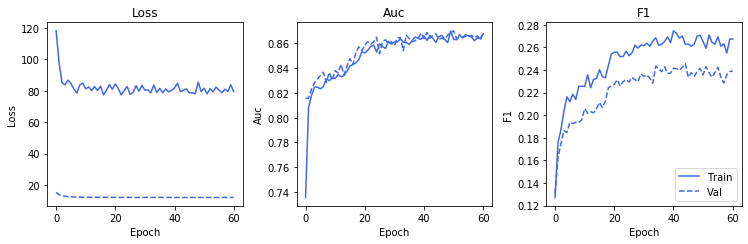

In [32]:
plot_metrics(history)

In [29]:
test_predictions = model.predict(trimmed_x_validation)

In [30]:
results = model.evaluate(
    trimmed_x_validation,
    y_validation_reshaped, 
    verbose=0
)

In [31]:
for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

loss :  78.53305424430154
tp :  10093.0
fp :  45179.0
tn :  825048.0
fn :  21680.0
accuracy :  0.9258769
precision :  0.18260603
recall :  0.31765965
auc :  0.83821714
f1 :  0.20075576
